In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS
MIN_COUNT = 10
TRAIN_SIZE = 0.7

In [3]:
def clean(df):
    df.drop('SimFinId', axis=1, inplace=True)

    df['Fiscal Period'] = df['Fiscal Period'].apply(lambda x: np.int64(x[1:]))

    df_numeric = df.select_dtypes(include=['float', 'int'])

    nan_rate = df_numeric.isna().sum()/df_numeric.shape[0]
    dropped_col = nan_rate[nan_rate >= 0.15].index.to_list()
    dropped_col

    df.drop(dropped_col, axis=1, inplace=True)
    df_numeric.drop(dropped_col, axis=1, inplace=True)

    nan_columns = df_numeric.columns[df_numeric.isna().any()].tolist()
    nan_columns_with_ticker = nan_columns[:]
    nan_columns_with_ticker.append('Ticker')

    nan_df = df[nan_columns_with_ticker]
    mean_df = nan_df.groupby('Ticker').mean()
    
    def fill_na(row, col_name):
        value = row[col_name]
        if not np.isnan(value):
            return value
        return mean_df.at[row['Ticker'], col_name]

    for nan_col in nan_columns:
        df[nan_col] = df.apply(lambda row: fill_na(row, nan_col), axis=1)
        
    # Drop all rows with NaN
    df.dropna(inplace=True)
    
    # Filter out ticker with more than MIN_COUNT rows
    df = df.groupby('Ticker').filter(lambda x: len(x) >= MIN_COUNT)
    
    return df

In [4]:
def analyse(df):
    grouped_df = df.groupby('Ticker').count()
    plt.hist(grouped_df.iloc[:, 0], bins=50)
    plt.title('distribution of companies income statements')
    plt.ylabel('Number of companies')
    plt.xlabel('Quarterly reports available')
    plt.show()

In [5]:
def split_train_test(df, filename_prefix):
    count_per_ticker = df['Ticker'].value_counts()
    test_count_per_ticker = count_per_ticker.apply(lambda x: max(1, int((1 - TRAIN_SIZE) * x)))
    # Training set
    train_df_full = df.groupby('Ticker').apply(lambda x: x[:-test_count_per_ticker[x.name]])
    train_df_full.to_csv(f'./hackathon_train_full/{filename_prefix}_train.csv', index=False)
    
    # Train and test report for each ticker
    tickers = df['Ticker']
    for ticker in tickers:
        test_count = test_count_per_ticker[ticker]
        df_ticker = df.loc[df['Ticker'] == ticker].sort_values(by='Report_Date')
        df_ticker.tail(test_count).to_csv(f"./hackathon_test/{filename_prefix}_{ticker}.csv", index=False)
#         df_ticker.iloc[:-test_count].to_csv(f"./hackathon_train/{filename_prefix}_{ticker}.csv", index=False)

/Users/nhanpotter/Coding/test/hackathon/venv/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


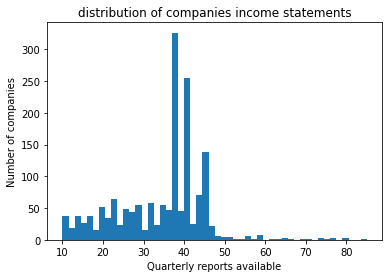

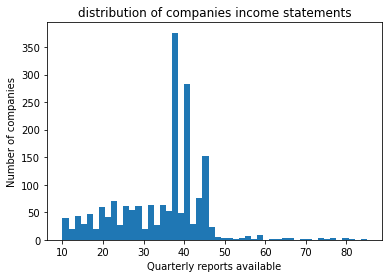

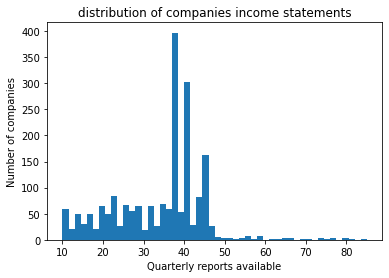

In [6]:
# All
files = [('df_income_extract_index.csv', 'df_income'), ('df_balance_extract_index.csv', 'df_balance'), ('df_cashflow_extract_index.csv', 'df_cashflow')]
for filename, prefix in files:
    df = pd.read_csv(filename)
    cleaned_df = clean(df)
    analyse(cleaned_df)
    split_train_test(cleaned_df, prefix)